### Predict the percentage of patients at a clinic who will use online appointments.

### Import Libraries

In [1]:
%load_ext tensorboard
from numpy.random import seed
seed(2)
#from tensorflow import set_random_seed
#set_random_seed(2)
import tensorflow as tf
from tensorflow import keras
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.python.data import Dataset
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
print(tf.__version__)

2.0.0


Using TensorFlow backend.


### Import Data

In [2]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
online_dataframe = pd.read_excel('OnlineUse.xlsx','OnlineUseData')
online_dataframe = online_dataframe.reindex(
np.random.permutation(online_dataframe.index))

In [5]:
# Encode categorical variable
selected_features = pd.DataFrame(online_dataframe)
selected_features['vendor'] = online_dataframe['vendor'].astype('category').cat.codes


In [6]:
# Check rows and columns
online_dataframe.shape

(6857, 22)

In [7]:
# Removing rows with missing values.
selected_features = selected_features[(selected_features != -97).all(axis=1)]
selected_features = selected_features[(selected_features != -98).all(axis=1)]

In [8]:
# Check rows and columns
selected_features.shape

(6360, 22)

In [9]:
# create a dataframe of all independent variables
training_features = selected_features.drop(columns =['OnlineAppointmentUse', 'ClinicID'])

In [10]:
# create a dataframe of target variables
output_targets = pd.DataFrame(selected_features, columns = ["OnlineAppointmentUse"])

In [11]:
# Choose the first 5000 examples for training.
training_examples = training_features.head(5000)
training_target = output_targets.head(5000)

# Normalize the training data
scaler = StandardScaler().fit(training_examples.values)
scaledf = scaler.transform(training_examples.values)
training_examples = pd.DataFrame(scaledf, index=training_examples.index, columns=training_examples.columns)


# Choose 1360 examples for validation.
validation_examples = training_features.tail(1360)
validation_target = output_targets.tail(1360)

# Normalize the validation data
scaler = StandardScaler().fit(validation_examples.values)
scaledf = scaler.transform(validation_examples.values)
validation_examples = pd.DataFrame(scaledf, index=validation_examples.index, columns=validation_examples.columns)

print("First few rows of training data: ")
training_examples.head(10)

First few rows of training data: 


,malepct,unemp,age16to24,age25to34,age35to44,age45to54,age55to64,age65to74,age75to84,age85plus,phoneeasy,onlineasy,race,longstdhealth,canmngownhealth,reducedability,prefgpalways,bcaaware,vendor,numpats
6248,0.3,0.1,-1.0,0.1,2.0,0.3,-0.5,-0.4,-0.8,-1.1,0.1,-0.3,-0.6,-0.2,-0.4,0.7,0.1,0.9,-0.8,-0.3
4833,-1.1,-1.1,-0.4,-0.5,-0.7,1.4,-0.7,0.3,0.9,1.9,0.7,1.1,0.6,0.3,0.2,-0.2,-0.0,-0.7,-0.8,0.9
369,0.9,0.7,0.6,0.1,0.2,-0.4,1.2,-0.7,-0.7,-1.8,0.4,1.8,0.6,0.3,-2.0,2.9,0.3,1.2,-0.8,0.9
3678,0.2,0.4,-0.3,1.4,2.3,-1.0,-1.4,-1.3,-1.2,-0.7,1.1,0.2,-1.8,-0.9,0.7,-0.5,1.5,0.4,-0.8,-0.9
1715,1.3,-0.4,0.0,-0.8,-1.6,-1.3,-0.1,2.1,2.5,2.0,0.7,-0.6,0.9,1.3,-0.4,-0.3,-0.2,-1.4,-0.8,0.3
6068,1.5,-0.5,-0.7,0.4,-0.0,-0.8,0.1,1.1,-0.1,-0.6,0.6,0.3,0.9,1.4,0.8,0.8,-1.6,0.2,-0.8,0.0
6544,-0.3,0.4,0.8,-1.2,-1.5,1.0,0.3,1.0,0.9,-0.2,-0.6,-0.6,0.8,1.1,-0.7,0.4,0.1,-0.4,1.1,-0.6
3500,-1.3,-0.6,-0.7,-1.3,1.6,-0.1,0.8,-0.3,0.1,1.0,-0.0,0.0,-0.3,-0.7,0.8,-1.7,-0.5,1.4,-0.8,0.9
1873,0.2,-1.1,0.1,-0.9,0.1,1.0,-0.2,0.2,-0.4,1.2,0.9,-0.1,0.1,-1.5,0.8,-2.1,0.6,0.6,-0.8,-0.3
1511,0.0,0.3,0.5,-1.7,0.9,-1.5,0.6,1.2,0.3,1.1,0.4,-0.2,0.6,-0.3,0.6,-0.2,-0.0,1.2,1.1,-0.8


### Check the baseline

In [12]:

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_target.describe())
print("Validation targets summary:")
display.display(validation_target.describe())

print("Check the baseline: ")
print("Mean Absolute Deviation of training target is: ")
display.display(training_target.mad()) # 0.068 precisely (calculated manually)

print("Mean Absolute Deviation of validation target is: ")
display.display(validation_target.mad())


Training examples summary:


,malepct,unemp,age16to24,age25to34,age35to44,age45to54,age55to64,age65to74,age75to84,age85plus,phoneeasy,onlineasy,race,longstdhealth,canmngownhealth,reducedability,prefgpalways,bcaaware,vendor,numpats
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-4.3,-1.1,-1.8,-2.2,-2.4,-4.2,-3.5,-2.7,-2.3,-1.8,-3.4,-4.8,-3.0,-3.9,-5.4,-3.2,-2.5,-2.6,-0.8,-1.4
25%,-0.7,-0.7,-0.6,-0.7,-0.7,-0.7,-0.6,-0.7,-0.7,-0.7,-0.7,-0.6,-0.5,-0.6,-0.6,-0.7,-0.7,-0.7,-0.8,-0.7
50%,-0.0,-0.3,-0.1,-0.1,-0.1,-0.0,0.0,0.0,-0.0,-0.1,0.2,0.1,0.4,0.0,0.1,-0.0,-0.1,-0.0,-0.8,-0.2
75%,0.6,0.5,0.5,0.6,0.6,0.6,0.6,0.7,0.7,0.6,0.8,0.7,0.7,0.7,0.7,0.7,0.7,0.7,1.1,0.5
max,5.1,13.2,11.0,6.4,4.7,4.1,3.6,3.9,3.8,6.6,1.5,1.9,1.0,5.7,2.0,4.2,2.6,2.9,2.4,12.0


Validation examples summary:


,malepct,unemp,age16to24,age25to34,age35to44,age45to54,age55to64,age65to74,age75to84,age85plus,phoneeasy,onlineasy,race,longstdhealth,canmngownhealth,reducedability,prefgpalways,bcaaware,vendor,numpats
count,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0,1360.0
mean,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-3.2,-1.1,-2.1,-2.0,-2.2,-3.2,-3.5,-2.7,-2.3,-1.8,-3.2,-6.2,-2.8,-3.6,-6.0,-3.1,-2.4,-2.4,-0.9,-1.3
25%,-0.6,-0.7,-0.7,-0.7,-0.7,-0.7,-0.6,-0.7,-0.7,-0.7,-0.7,-0.6,-0.6,-0.6,-0.6,-0.7,-0.7,-0.7,-0.9,-0.7
50%,-0.0,-0.3,-0.1,-0.1,-0.1,0.0,0.0,0.0,-0.0,-0.1,0.1,0.1,0.4,0.1,0.1,0.0,-0.0,0.0,-0.9,-0.2
75%,0.6,0.5,0.5,0.5,0.6,0.7,0.7,0.7,0.6,0.6,0.8,0.8,0.8,0.7,0.7,0.7,0.7,0.7,1.1,0.4
max,4.1,4.6,4.9,7.1,4.1,4.0,3.6,3.2,3.7,4.2,1.5,1.9,1.0,2.8,2.1,4.1,2.7,2.8,2.4,9.6


Training targets summary:


,OnlineAppointmentUse
count,5000.0
mean,0.1
std,0.1
min,0.0
25%,0.1
50%,0.1
75%,0.2
max,0.6


Validation targets summary:


,OnlineAppointmentUse
count,1360.0
mean,0.1
std,0.1
min,0.0
25%,0.1
50%,0.1
75%,0.2
max,0.6


Check the baseline: 
Mean Absolute Deviation of training target is: 


OnlineAppointmentUse   0.1
dtype: float64

Mean Absolute Deviation of validation target is: 


OnlineAppointmentUse   0.1
dtype: float64

### Build model

In [13]:
baseline_model = keras.Sequential([
    keras.layers.Dense(20, activation=tf.nn.relu,
                       input_shape=(training_examples.shape[1],)),
    keras.layers.Dense(7, activation=tf.nn.relu),
    keras.layers.Dense(7, activation=tf.nn.relu),
    keras.layers.Dense(1)

  ])


baseline_model.compile(loss='mse',
                optimizer="rmsprop",
                metrics=['mse'])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 631
Trainable params: 631
Non-trainable params: 0
_________________________________________________________________


### Fit Model

In [56]:
EPOCHS = 50
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(monitor = 'val_loss',patience=3)
b_history = baseline_model.fit(training_examples, training_target, epochs=EPOCHS,
                    validation_data= (validation_examples, validation_target), verbose=1,
                    callbacks=[early_stopping_monitor])

Train on 5000 samples, validate on 1360 samples
Epoch 1/50
5000/5000 [==============================] - 1s 174us/sample - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/50
5000/5000 [==============================] - 0s 49us/sample - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 3/50
5000/5000 [==============================] - 0s 56us/sample - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 4/50
5000/5000 [==============================] - 0s 47us/sample - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 5/50
5000/5000 [==============================] - 0s 46us/sample - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 6/50
5000/5000 [==============================] - 0s 48us/sample - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/50
5000/5000 [==============================] - 0s 46us/sample - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0030 - val_mse:

### Check the minimum and maximum error

In [57]:
print("Minimum validation error is: ", min(b_history.history['val_mse']))
print("Maximum validation error is: ", max(b_history.history['val_mse']))

Minimum validation error is:  0.002723648
Maximum validation error is:  0.0067848964


In [58]:
print("Minimum model error is: ", min(b_history.history['mse']))
print("Maximum model error is: ", max(b_history.history['mse']))

Minimum model error is:  0.002356834
Maximum model error is:  0.026455875


### Predictions

In [59]:
valpreds = baseline_model.predict_on_batch(validation_examples.iloc[1:10])
print(valpreds)

tf.Tensor(
[[ 0.2248787 ]
 [-0.01017716]
 [ 0.16120403]
 [ 0.11545393]
 [ 0.1252439 ]
 [ 0.2636764 ]
 [ 0.11467865]
 [ 0.06194291]
 [ 0.19638404]], shape=(9, 1), dtype=float32)


In [60]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(validation_target.iloc[1:10])

      OnlineAppointmentUse
4230                   0.1
5472                   0.0
4070                   0.1
5471                   0.1
4535                   0.1
579                    0.3
6745                   0.1
5385                   0.1
2850                   0.1


### Plot results

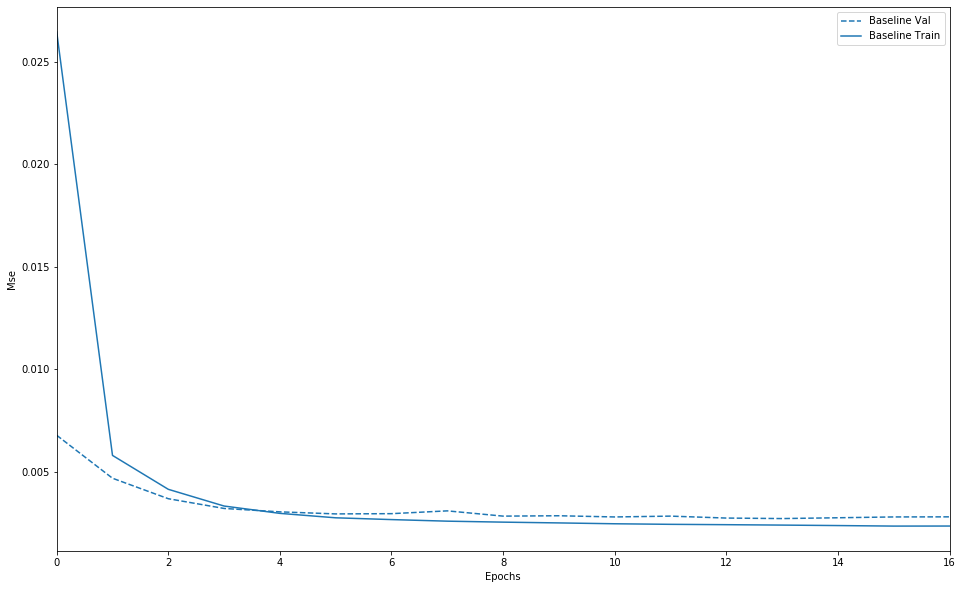

In [61]:
import matplotlib.pyplot as plt


def plot_history(histories, key='mse'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  #plt.ylim([0,0.05])

plot_history([('baseline', b_history)])

#### Conclusion:

The output type of this model is continuous, so the activation function used here is linear, loss function as 'mse', optimizer as 'rmsprop' and metric as 'mse'. The baseline is mean absolute deviation of target variable of training data. The performance of this model is exceeding the performance of baseline. The baseline is 0.068 (Mean Absolute Deviation of target training variable). The minimum and maximum validation error is 0.002 and 0.006 respectively.